In [1]:
import os
import re
import pandas as pd
from time import time
import datetime
import numpy as np
import spacy
import nltk
import wrds
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
import json

In [2]:
RANDOM_SEED = 7
DATA_DIR = "../data"
INTERM_DIR = '../compiled_data'

# note: wsb=wallstreetbets
wsb_data_path = os.path.join(DATA_DIR, 'old_wsb_comments/wsbData.json')
stock_data_path = os.path.join(DATA_DIR, 'GME')

# db = wrds.Connection(wrds_username='debabech', wrds_passeword='Electro1004$')
# db.create_pgpass_file()
# permcos = db.get_table(library='crsp', table='stocknames')[
#     ["permco", "ticker"]]

# efficiency and accuracy --> "en_core_web_trf"
nlp = spacy.load("en_core_web_sm")

In [23]:
# Define functions to load our data

# def load_wsb_data(data_path, nrows=None, cols=['author', 'body','created_utc', 'score', 'link_id', 'is_submitter']):
#     "Load wsb data, nrows None indicates all rows, otherwise specified integer of rows"
#     data = pd.read_csv(wsb_data_path, nrows = nrows, delimiter=',', usecols=cols)
    
#     data = data[data['author'] != '[deleted]']
#     data = data[data['body'] != '[deleted]']
#     data = data[data['body'] != '[removed]']
    
#     data['created_utc'] = pd.to_numeric(data['created_utc'], errors='coerce')
#     data = data.dropna(subset=['created_utc'])
#     data['created_utc'] = data['created_utc'].astype(int)

#     data['created_utc'] = data['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
#     data = data.loc[data['created_utc'] > '2000']
#     return data

def load_wsb_data(data_path, cols = ['body', 'score', 'created_utc','author','link_id']):
    
    data = []

    with open(data_path, encoding='latin-1') as f:
        for line in f:
            doc = json.loads(line)
            lst = [doc['body'], doc['score'], doc['created_utc'], doc['author'], doc['link_id']]
            data.append(lst)
    
    data = pd.DataFrame(data=data, columns=cols)
    data = data[data['author'] != '[deleted]']
    data = data[data['body'] != '[deleted]']
    data = data[data['body'] != '[removed]']
    
    data['created_utc'] = pd.to_numeric(data['created_utc'], errors='coerce')
    data = data.dropna(subset=['created_utc'])
    data['created_utc'] = data['created_utc'].astype(int)
    
    data['created_utc'] = data['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    
    return data

def load_stock_wrds(ticker):
    permco = permcos[permcos.ticker == ticker].permco.values[0]
    # to 2021-03-25 ??
    req = f"select prc, date from crsp.dsf where permco in ({permco}) and date >='2012-01-31' and date <='2021-02-16'"
    asset = db.raw_sql(req, date_cols=['date'])
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.prc).diff(1)

    return asset["log_ret"]


def load_stock_yh(ticker):
    asset = yf.download(ticker, interval='1d',
                        start="2012-01-31", end="2021-02-16")
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.Close - asset.Open) #np.log(asset.Open).diff(1).shift(-1)

    return asset["log_ret"]


In [24]:
# Load the WSB textual data
wsb_df = load_wsb_data(wsb_data_path)

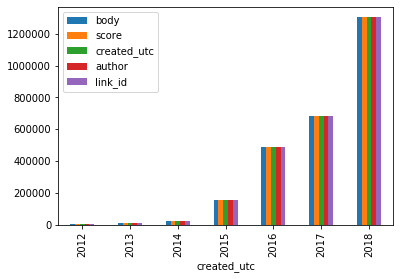

In [26]:
wsb_df.groupby(wsb_df["created_utc"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.year).count().plot(kind="bar")

In [27]:
class PreProcessing:

    def __init__(self, wsb_data, lemmatize=True, lower_case=True, rem_stopwords=True, rem_punctuation=True):
        """
        Initialise all class parameters

        :param data: nonempty pandas dataframe, wsb dataframe 
        :param lemmatize: bool, whether to perform lemmatization
        :param lower_case: bool, whether to lowercase
        :param rem_stopwords: bool, whether to remove stopwords
        :param tokenize: bool, whether to tokenize
        """

        self.wsb_data = wsb_data
        self.lemmatize = lemmatize
        self.lower_case = lower_case
        self.rem_stopwords = rem_stopwords
        self.rem_punctuation = rem_punctuation

    # Ensure Parameter types
    # K: need to add to this one gradually as we add columns that we use etc.
    @property
    def wsb_data(self):
        return self._wsb_data

    @wsb_data.setter
    def wsb_data(self, wsb_data):

        req_columns = ['author', 'body', 'created_utc']
        str_columns = ['body']
        date_columns = ['created_utc']

        # Ensure the provided object is a dataframe
        if not isinstance(wsb_data, pd.DataFrame):
            raise Exception("The provided data must be a pandas Dataframe")

        # Ensure wsb dataframe is non empty
        if wsb_data.shape[0] == 0:
            raise Exception("Provided Dataframe is empty")

        # Ensure all required columns are provided
        missing_columns = set(req_columns).difference(
            set(wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} are missing from the provided dataframe!")

        # Ensure all column names don't have unexpected periods
        if '.' in list(''.join(wsb_data.columns.tolist())):
            raise Exception("All Column names must not include periods :'.'")

        # Ensure all string columns are strings
        non_str_columns = set(str_columns).difference(
            set(wsb_data.select_dtypes(include='object')))
        if len(non_str_columns) > 0:
            raise Exception(
                f'The columns {non_str_columns} are expected as string (pandas object) columns.')

        self._wsb_data = wsb_data

    @property
    def lemmatize(self):
        return self._lemmatize

    @lemmatize.setter
    def lemmatize(self, lemmatize):
        if not isinstance(lemmatize, bool) and lemmatize is not None:
            raise Exception(
                'lemmatize must be provided as a boolean parameter (True/False) or None to the class')
        self._lemmatize = lemmatize

    @property
    def lower_case(self):
        return self._lower_case

    @lower_case.setter
    def lower_case(self, lower_case):
        if not isinstance(lower_case, bool):
            raise Exception(
                'lower_case must be provided as a boolean parameter (True/False) to the class')
        self._lower_case = lower_case

    @property
    def rem_stopwords(self):
        return self._rem_stopwords

    @rem_stopwords.setter
    def rem_stopwords(self, rem_stopwords):
        if not isinstance(rem_stopwords, bool):
            raise Exception(
                'rem_stopwords must be provided as a boolean parameter (True/False) to the class')
        self._rem_stopwords = rem_stopwords

    @property
    def rem_punctuation(self):
        return self._rem_punctuation

    @rem_punctuation.setter
    def rem_punctuation(self, rem_punctuation):
        if not isinstance(rem_punctuation, bool):
            raise Exception(
                'rem_punctuation must be provided as a boolean parameter (True/False) to the class')
        self._rem_punctuation = rem_punctuation

#     @property
#     def tokenize(self):
#         return self._tokenize

#     @tokenize.setter
#     def tokenize(self, tokenize):
#         if not isinstance(tokenize, bool):
#             raise Exception(
#                 'tokenize must be provided as a boolean parameter (True/False) to the class')
#         self._tokenize = tokenize

    def clean_textual_data(self, textual_columns):

        # Ensure the provided textual columns exist, and if single string column name convert it into a list
        if len(textual_columns) < 1:
            raise Exception(
                'The number of textual columns to clean must be greater than 0')
        if isinstance(textual_columns, str):
            textual_columns = [textual_columns]
        missing_columns = set(textual_columns).difference(
            set(self.wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} to clean are missing from the wsb dataframe!")
            
        def rem_null(self, col_name):
            self.wsb_data = self.wsb_data[self.wsb_data[col_name].notna()]
            return self.wsb_data

        def lower_case_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].str.lower()
            return self.wsb_data

        def lemmatize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            lemmatizer = nltk.stem.WordNetLemmatizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def stemming_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            stemmer = nltk.stem.porter.PorterStemmer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [stemmer.stem(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def tokenize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def rem_punctuation_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if w.isalnum()])
            return self.wsb_data

        def rem_stopwords_fn(self, col_name):
            "stopwords dictionary considered English, wsb is an english forum"
            remove_elements = set(nltk.corpus.stopwords.words('english'))
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if not w in remove_elements])
            return self.wsb_data

        def remove_tokenization(self, col_name):
            "Necessary as final step to untokenize in case desired, tokenization required for other functions to not break"
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: ' '.join(x))
            return self.wsb_data

        for textual_col in textual_columns:
            
            rem_null(self, textual_col)

            if self.lower_case:
                lower_case_fn(self, textual_col)

            # lemmatize tokens if true, if false, stem tokens, if None then just tokenize
            if self.lemmatize:
                lemmatize_fn(self, textual_col)
            elif self.lemmatize == False:
                stemming_fn(self, textual_col)
            else:
                tokenize_fn(self, textual_col)

            if self.rem_punctuation:
                rem_punctuation_fn(self, textual_col)
            if self.rem_stopwords:
                rem_stopwords_fn(self, textual_col)
                
            remove_tokenization(self, textual_col)

        return self.wsb_data

In [29]:
WSBPreProcessing = PreProcessing(
    wsb_df, lemmatize=None, lower_case=True, rem_stopwords=True, rem_punctuation=True)
WSBPreProcessing.clean_textual_data('body')
useful_columns = ['author', 'body', 'created_utc', 'score', 'link_id']
WSB_preprocessed_data = WSBPreProcessing.wsb_data[useful_columns]

In [30]:
def rem_url_at(df):
    raw = []
    for sentence in tqdm(df['body']):
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'
                          '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sentence)
        sentence = re.sub("(@[A-Za-z0-9_]+)", "", sentence)
        raw.append(sentence)
    df['body'] = raw

    return df


def tagging(df):
    pos,tag,dep,shape = [],[],[],[]
    for sentence in tqdm(df['body']):
        pos_tmp,tag_tmp,dep_tmp,shape_tmp = [],[],[],[]
        for token in nlp(sentence):
            pos_tmp.append(token.pos_)
            tag_tmp.append(token.tag_)
            dep_tmp.append(token.dep_)
            shape_tmp.append(token.shape_)
        pos.append(pos_tmp)
        tag.append(tag_tmp)
        dep.append(dep_tmp)
        shape.append(shape_tmp)

    df['Pos'] = pos
    df['Tag'] = tag
    df['Dep'] = dep
    df['Shape'] = shape

    return df

In [31]:
WSB_preprocessed_data = rem_url_at(WSB_preprocessed_data)
#WSB_preprocessed_data = tagging(WSB_preprocessed_data)

WSB_preprocessed_data.replace('', np.nan, inplace=True)
WSB_preprocessed_data = WSB_preprocessed_data.dropna(how='any', axis=0)
WSB_preprocessed_data = WSB_preprocessed_data[WSB_preprocessed_data['body'].map(
    lambda d: len(d)) > 0]


100%|██████████| 2657694/2657694 [00:04<00:00, 582670.75it/s]


## Sentiment Analyser
- Flair
- Vader
- Blob

In [32]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')


2022-01-02 16:15:34,292 loading file /home/kamran/.flair/models/sentiment-en-mix-distillbert_4.pt


In [33]:
import tqdm.notebook as tq

def sentiment_analyser(df, v=True, f=False, b=False, r_vader=0.8, r_fler=0.1, r_blob=0.1):

    df_fler, df_vader, df_blob = [], [], []
    for sentence in tqdm(df['body'], position=0):
        if v:
            df_vader.append(vader(sentence))
        if f:
            df_fler.append(fler(sentence))
        if b:
            df_blob.append(blob(sentence))
    if v: 
        df['VADER'] = df_vader
    if f: 
        df['FLAIR'] = df_fler
    if b:
        df['BLOB'] = df_blob

    if v and f and b:
        df['compound'] = df['VADER']*r_vader + \
            df['FLAIR']*r_fler + df['BLOB']*r_blob
    elif v and f and not b:
        df['compound'] = df['VADER']*(r_vader+r_blob) + df['FLAIR']*r_fler
    elif v and b and not f:
        df['compound'] = df['VADER']*(r_vader+r_fler) + df['BLOB']*r_blob
    else:
        df['compound'] = df['VADER']

    return df


def vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(sentence)['compound']
    return float(sentiment)


def fler(sentence):
    s = Sentence(sentence)
    classifier.predict(s)
    sentiment = str(s.labels[0])
    num = float(re.findall(r'\d+\.\d+', sentiment)[0])
    if sentiment.find('POSITIVE') == -1:
        num = num * -1
    return num


def blob(sentence):
    sentiment = TextBlob(sentence).sentiment.polarity
    return sentiment


#WSB_preprocessed_data = sentiment_analyser(WSB_preprocessed_data)

In [34]:
import multiprocessing

n_splits = 8
n_rows = len(WSB_preprocessed_data)
chunks = [[int(i * n_rows/n_splits), int((i+1) * n_rows/n_splits)]  for i in range(n_splits)]

# function to perform vader analysis on portion of the table
def vader_worker(row_range):
    return sentiment_analyser(WSB_preprocessed_data.iloc[row_range[0]:row_range[1]])


In [35]:
p = multiprocessing.Pool(processes=n_splits) 
WSB_preprocessed_data = p.map(vader_worker, chunks)
p.close() 
del p

WSB_preprocessed_data = pd.concat(WSB_preprocessed_data)
WSB_preprocessed_data.to_pickle(INTERM_DIR+'/SAprocessed/wsb_pkl')

 99%|█████████▊| 309884/314229 [1:19:32<00:57, 76.12it/s]/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|█████████▉| 312725/314229 [1:20:02<00:12, 120.07it/s]/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

# Aggregate by day

In [3]:
def load_yfinance_data(ticker):
    
    tmp_ = yf.Ticker(ticker)

    # get historical market data
    hist = tmp_.history(period="10Y")
    hist = hist.drop(['Stock Splits', 'Dividends','Close'], axis=1)
    hist.columns = [ticker + '_' + x for x in hist.columns]
    return hist

SPY = load_yfinance_data('SPY')
DJI = load_yfinance_data('DJI')
NDAQ = load_yfinance_data('NDAQ')
INX = load_yfinance_data('INX')
NDXE = load_yfinance_data('^NDXE')
OEX = load_yfinance_data('OEX')

df_tickers = pd.concat([SPY, DJI, NDAQ, INX, NDXE, OEX], axis=1)
df_tickers = df_tickers.reset_index()
df_tickers['Date'] = pd.to_datetime(df_tickers['Date'], unit='s')

In [4]:
df_tickers.head()

,Date,SPY_Open,SPY_High,SPY_Low,SPY_Volume,DJI_Open,DJI_High,DJI_Low,DJI_Volume,NDAQ_Open,...,INX_Low,INX_Volume,^NDXE_Open,^NDXE_High,^NDXE_Low,^NDXE_Volume,OEX_Open,OEX_High,OEX_Low,OEX_Volume
0,2012-01-03,105.490859,106.002793,105.218378,193697900,12397.400391,12397.400391,12397.400391,0.0,21.268416,...,0.285,15000.0,1396.780029,1402.180054,1387.050049,0,1.942,1.942,1.942,0.0
1,2012-01-04,105.028482,105.532157,104.623893,127186500,12418.400391,12418.400391,12418.400391,0.0,20.979511,...,0.285,0.0,1384.030029,1387.680054,1375.510010,0,2.039,2.039,2.039,0.0
2,2012-01-05,104.871625,105.878968,104.392720,173895000,12415.700195,12415.700195,12415.700195,0.0,20.699105,...,0.285,0.0,1383.910034,1400.829956,1377.660034,0,1.988,2.006,1.988,0.0
3,2012-01-06,105.854189,105.870707,105.102810,148050000,12359.900391,12359.900391,12359.900391,0.0,20.928525,...,0.285,0.0,1400.640015,1406.609985,1394.630005,0,10.000,10.000,10.000,0.0
4,2012-01-09,105.689026,105.837645,105.201869,99530200,12392.700195,12392.700195,12392.700195,0.0,20.741586,...,0.285,0.0,1407.670044,1414.010010,1397.550049,0,9.840,10.150,9.840,962.0


In [5]:
WSB_preprocessed_data = pd.read_pickle(INTERM_DIR+'/SAprocessed/wsb_pkl')

# db = wrds.Connection(wrds_username='debabech', wrds_passeword='Electro1004$')
# db.create_pgpass_file()
# permcos = db.get_table(library='crsp', table='stocknames')[
#     ["permco", "ticker"]]

In [6]:
WSB_preprocessed_data['date'] = WSB_preprocessed_data["created_utc"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.date
WSB_preprocessed_data['date'] = pd.to_datetime(WSB_preprocessed_data['date'])
WSB_preprocessed_data['score'] = WSB_preprocessed_data['score'].astype(int)
WSB_preprocessed_data['score'] = WSB_preprocessed_data[['score']].apply(lambda x: x.fillna(x.mean()))
WSB_preprocessed_data['score'] = np.log(WSB_preprocessed_data['score']+1-WSB_preprocessed_data['score'].min())

In [7]:
WSB_preprocessed_data = WSB_preprocessed_data.groupby('date')[['score','compound']].agg({'compound' : ['mean', 'median', 'min', 'max'], 
                                                                                         'score' : ['mean', 'median', 'min', 'max']}).reset_index()

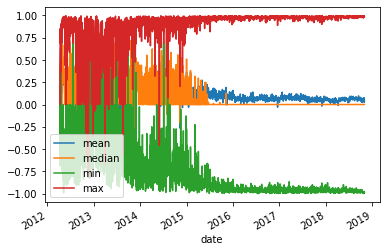

In [8]:
WSB_preprocessed_data.plot(x = 'date', y = 'compound')
plt.show()

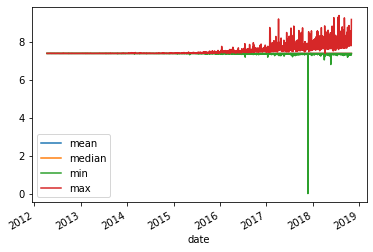

In [9]:
WSB_preprocessed_data.plot(x = 'date', y = 'score')
plt.show()

In [10]:
WSB_preprocessed_data.columns = WSB_preprocessed_data.columns.map('_'.join)

### Fast Fourier Transform on Sentiment Analyses

In [11]:
from scipy.fftpack import fft, ifft

def fourier(df, n_dimensions, col):
    for n in n_dimensions:
        n = round(n)
        tmp_ = fft(df[col].values)
        tmp_[n:-n] = 0
        df['fourier_'+col+str(n)] = np.abs(ifft(tmp_))
    return df

# how to choose the values of fourier?
l = len(WSB_preprocessed_data)
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [1,2,3], 'compound_mean')
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [1,2,3], 'score_mean')

In [12]:
df_tickers = df_tickers.set_index('Date')

# Calculate returns
returns = df_tickers.pct_change() # simple linear returns
log_rets = np.log(2+returns)
log_rets = log_rets.replace([np.inf, -np.inf], np.nan)
log_rets = log_rets.dropna(axis=1, thresh=len(log_rets)/2)
log_rets = log_rets.dropna(axis=0, how='all')
log_rets = log_rets.fillna(log_rets.mean())

In [13]:
def merged_df(df, df_tickers, column='compound', freq='D', var=1.1):
    final_df = pd.merge(df, df_tickers, left_on='date_', right_on='Date')
    final_df = final_df.set_index('date_')
    return final_df

final_df = merged_df(WSB_preprocessed_data, log_rets)

final_df.to_pickle(INTERM_DIR+f'/clean/Final_df_pkl')

In [14]:
final_df.head()

,compound_mean,compound_median,compound_min,compound_max,score_mean,score_median,score_min,score_max,fourier_compound_mean1,fourier_compound_mean2,...,INX_Open,INX_High,INX_Low,INX_Volume,^NDXE_Open,^NDXE_High,^NDXE_Low,OEX_Open,OEX_High,OEX_Low
date_,,,,,,,,,,,,,,,,,,,,,
2012-04-11,0.057350,0.0000,-0.5994,0.6901,7.375151,7.374942,7.374629,7.377759,0.142057,0.138407,...,0.693147,0.693147,0.693147,0.609238,0.688978,0.690117,0.697620,0.700851,0.700851,0.700851
2012-04-12,0.425800,0.4258,0.0000,0.8516,7.374629,7.374629,7.374629,7.374629,0.142161,0.138670,...,0.693147,0.693147,0.693147,0.609238,0.694536,0.697681,0.695022,2.123173,2.147441,2.123173
2012-04-13,-0.345400,-0.3454,-0.6908,0.0000,7.374629,7.374629,7.374629,7.374629,0.142265,0.138932,...,0.693147,0.693147,0.693147,0.609238,0.696082,0.690780,0.692705,0.127675,0.124416,0.127675
2012-04-16,0.636900,0.6369,0.6369,0.6369,7.374629,7.374629,7.374629,7.374629,0.142473,0.139458,...,0.693147,0.693147,0.693147,0.609238,0.692256,0.691252,0.688289,2.141814,2.141814,2.112674
2012-04-17,0.401885,0.4019,-0.4588,0.9019,7.375014,7.374629,7.374629,7.377759,0.142576,0.139721,...,0.693147,0.693147,0.693147,0.609238,0.691226,0.697775,0.698697,0.111568,0.111568,0.115113


In [15]:
y = df_tickers['SPY_Open']
y = y.pct_change()[1:].apply(lambda x: 0 if x < 0 else 1)
X = final_df.shift(-1)

In [16]:
window_lag = 6

def create_windowed_data(X, window_lag, final_df):

    for lag in range(window_lag-1):
        lagged_df = final_df.shift(-lag-2)
        lagged_df.columns = [x + '_t' + str(lag+2) for x in lagged_df.columns]

        X = pd.concat([X, lagged_df], axis=1)

    X = X.dropna(axis=0)
    return X

X = create_windowed_data(X, window_lag, final_df)
display(X.head())

y = y[y.index.isin(X.index)]

X, y = X.to_numpy(), y.to_numpy()

,compound_mean,compound_median,compound_min,compound_max,score_mean,score_median,score_min,score_max,fourier_compound_mean1,fourier_compound_mean2,...,INX_Open_t6,INX_High_t6,INX_Low_t6,INX_Volume_t6,^NDXE_Open_t6,^NDXE_High_t6,^NDXE_Low_t6,OEX_Open_t6,OEX_High_t6,OEX_Low_t6
date_,,,,,,,,,,,,,,,,,,,,,
2012-04-11,0.425800,0.4258,0.0000,0.8516,7.374629,7.374629,7.374629,7.374629,0.142161,0.138670,...,0.693147,0.693147,0.693147,0.609238,0.690067,0.685694,0.692314,0.717272,0.717272,0.717272
2012-04-12,-0.345400,-0.3454,-0.6908,0.0000,7.374629,7.374629,7.374629,7.374629,0.142265,0.138932,...,0.693147,0.693147,0.675129,0.609238,0.684785,0.684135,0.683322,0.679080,0.679080,0.679080
2012-04-13,0.636900,0.6369,0.6369,0.6369,7.374629,7.374629,7.374629,7.374629,0.142473,0.139458,...,0.675129,0.675129,0.693147,0.000000,0.693294,0.693428,0.693395,2.212984,2.232934,2.209755
2012-04-16,0.401885,0.4019,-0.4588,0.9019,7.375014,7.374629,7.374629,7.377759,0.142576,0.139721,...,0.693147,0.693147,0.693147,0.609238,0.694160,0.697590,0.698168,0.693147,0.682024,0.694962
2012-04-17,0.032600,0.0326,-0.2960,0.3612,7.374942,7.374942,7.374629,7.375256,0.142680,0.139984,...,0.693147,0.693147,0.655407,0.609238,0.697875,0.699533,0.697991,0.101462,0.101462,0.101462


### Splitting

In [31]:
import sklearn
# print(sklearn.__version__) # make sure > 0.24

trainsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_lag, test_size = int(0.3 * X.shape[0]))

for train_index, rem_index in trainsplit.split(X):

    X_train, X_rem = X[train_index], X[rem_index]
    y_train, y_rem = y[train_index], y[rem_index]
    

valsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_lag, test_size = int(0.33 * X_rem.shape[0]))
for val_index, test_index in valsplit.split(X_rem):

    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1133, 210)
(321, 210)
(161, 210)


In [37]:
import pickle as pkl
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'wb') as f:
    pkl.dump([X_train, y_train, X_val, y_val, X_test, y_test], f)

In [39]:
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pkl.load(f)